# Investigating Fandango Movie Ratings

In October 2015, a data journalist named Walt Hickey analyzed movie ratings data and found strong evidence to suggest that Fandango's rating system was biased and dishonest (<a href="https://fandango.com">Fandango</a> is an online movie ratings aggregator). He published his analysis <a href="https://fivethirtyeight.com/features/fandango-movies-ratings/">in this article</a>.

Hickey found that there's a significant discrepancy between the number of stars displayed to users and the actual rating, which he was able to find in the HTML of the page. He was able to find that:

- The actual rating was almost always rounded up to the nearest half-star. 
- In the case of 8% of the ratings analyzed, the rounding up was done to the nearest whole star. 
- For one movie rating, the rounding off was completely bizarre: from a rating of 4 in the HTML of the page to a displayed rating of 5 stars.


<img src="https://s3.amazonaws.com/dq-content/288/s1gp_actual_vs_displayed.png" alt="">


In this project, we'll analyze more recent movie ratings data to determine whether there has been any change in Fandango's rating system after Hickey's analysis.

We'll work with two samples of movie ratings:the data in one sample was collected previous to Hickey's analysis, while the other sample was collected after. Let's start by reading in the two samples (which are stored as CSV files) and getting familiar with their structure.

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np

previous = pd.read_csv('fandango_score_comparison.csv')
after =  pd.read_csv('movie_ratings_16_17.csv')

previous.head()

,FILM,RottenTomatoes,RottenTomatoes_User,Metacritic,Metacritic_User,IMDB,Fandango_Stars,Fandango_Ratingvalue,RT_norm,RT_user_norm,...,IMDB_norm,RT_norm_round,RT_user_norm_round,Metacritic_norm_round,Metacritic_user_norm_round,IMDB_norm_round,Metacritic_user_vote_count,IMDB_user_vote_count,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),74,86,66,7.1,7.8,5.0,4.5,3.70,4.3,...,3.90,3.5,4.5,3.5,3.5,4.0,1330,271107,14846,0.5
1,Cinderella (2015),85,80,67,7.5,7.1,5.0,4.5,4.25,4.0,...,3.55,4.5,4.0,3.5,4.0,3.5,249,65709,12640,0.5
2,Ant-Man (2015),80,90,64,8.1,7.8,5.0,4.5,4.00,4.5,...,3.90,4.0,4.5,3.0,4.0,4.0,627,103660,12055,0.5
3,Do You Believe? (2015),18,84,22,4.7,5.4,5.0,4.5,0.90,4.2,...,2.70,1.0,4.0,1.0,2.5,2.5,31,3136,1793,0.5
4,Hot Tub Time Machine 2 (2015),14,28,29,3.4,5.1,3.5,3.0,0.70,1.4,...,2.55,0.5,1.5,1.5,1.5,2.5,88,19560,1021,0.5


In [2]:
after.head()

,movie,year,metascore,imdb,tmeter,audience,fandango,n_metascore,n_imdb,n_tmeter,n_audience,nr_metascore,nr_imdb,nr_tmeter,nr_audience
0,10 Cloverfield Lane,2016,76,7.2,90,79,3.5,3.80,3.60,4.50,3.95,4.0,3.5,4.5,4.0
1,13 Hours,2016,48,7.3,50,83,4.5,2.40,3.65,2.50,4.15,2.5,3.5,2.5,4.0
2,A Cure for Wellness,2016,47,6.6,40,47,3.0,2.35,3.30,2.00,2.35,2.5,3.5,2.0,2.5
3,A Dog's Purpose,2017,43,5.2,33,76,4.5,2.15,2.60,1.65,3.80,2.0,2.5,1.5,4.0
4,A Hologram for the King,2016,58,6.1,70,57,3.0,2.90,3.05,3.50,2.85,3.0,3.0,3.5,3.0


We'll isolate the columns that offer information about Fandango's ratings in separate variables so we have just the data we're interested in more readily available for later use.

In [3]:
previous_clear = previous[['FILM', 'Fandango_Stars', 'Fandango_Ratingvalue', 'Fandango_votes', 'Fandango_Difference']].copy()
after_clear = after[['movie', 'year', 'fandango']].copy()
previous_clear.head()

,FILM,Fandango_Stars,Fandango_Ratingvalue,Fandango_votes,Fandango_Difference
0,Avengers: Age of Ultron (2015),5.0,4.5,14846,0.5
1,Cinderella (2015),5.0,4.5,12640,0.5
2,Ant-Man (2015),5.0,4.5,12055,0.5
3,Do You Believe? (2015),5.0,4.5,1793,0.5
4,Hot Tub Time Machine 2 (2015),3.5,3.0,1021,0.5


In [4]:
after_clear.head()

,movie,year,fandango
0,10 Cloverfield Lane,2016,3.5
1,13 Hours,2016,4.5
2,A Cure for Wellness,2016,3.0
3,A Dog's Purpose,2017,4.5
4,A Hologram for the King,2016,3.0


### About data sets: 

First one contains movies must have had at least 30 fan ratings on Fandango's website at the time of sampling (Aug. 24, 2015).

Second one contains movie ratings data for 214 of the most popular movies (unclear how many from the README.md or from the data) released in 2016 and 2017. In the future, we will only use films released in 2016.

As we can see,  sampling processes were not random. The resulting samples are very unlikely to be representative of the population we're interested in describing.

The sampling was clearly not random because not every movie had the same chance to be included in the sample — some movies didn't have a chance at all (like those having under 30 fan ratings). It's questionable whether this sample is representative of the entire population we're interested to describe. It seems more likely that it isn't, mostly because this sample is subject to temporal trends — e.g. movies in 2015 might have been outstandingly good or bad compared to other years.

### Changing the Goal of our Analysis

Despite the fact that our sample is not random, we can try to estimate the distribution of the rating in the after data set, and analyze whether this distribution is close to the 'Fandango_Stars' or 'Fandango_Ratingvalue' distribution in the previous data set.

### Isolating the Samples We Need 

With this new research goal, we have two populations of interest:

- All Fandango's ratings for popular movies released in 2015.
- All Fandango's ratings for popular movies released in 2016.


Although one of the sampling criteria in our second sample is movie popularity, the sample doesn't provide information about the number of fan ratings. We should be skeptical once more and ask whether this sample is truly representative and contains popular movies (movies with over 30 fan ratings).

One quick way to check the representativity of this sample is to sample randomly 10 movies from it and then check the number of fan ratings ourselves on Fandango's website. Ideally, at least 8 out of the 10 movies have 30 fan ratings or more.

In [5]:
after_clear.sample(10, random_state = 1)

,movie,year,fandango
108,Mechanic: Resurrection,2016,4.0
206,Warcraft,2016,4.0
106,Max Steel,2016,3.5
107,Me Before You,2016,4.5
51,Fantastic Beasts and Where to Find Them,2016,4.5
33,Cell,2016,3.0
59,Genius,2016,3.5
152,Sully,2016,4.5
4,A Hologram for the King,2016,3.0
31,Captain America: Civil War,2016,4.5


As of January 2021, these are the fan ratings we found:

|   Movie	|   Rating	|
|---	|---	|
|   Mechanic: Resurrection	|  25,637 	|
|   Warcraft|   31,638	|
|Max Steel|  6,846 	|
|Me Before You|  30,710 	|
|	Fantastic Beasts and Where to Find Them| 88,034  	|
|Cell|   3,847	|
|Genius|2,894|
|Sully|  48,575 	|
|A Hologram for the King|10,238|
|	Captain America: Civil War|  180,265 |

100% of the movies in our sample are popular.

Let's also double-check the other data set for popular movies. The documentation states clearly that there're only movies with at least 30 fan ratings, but it should take only a couple of seconds to double-check here.

In [6]:
sum(previous_clear['Fandango_votes'] < 30)

0

For our purposes, we'll need to isolate only the movies released in 2015 and 2016.

Let's start with Hickey's data set and isolate only the movies released in 2015. There's no special column for the releasing year, but we should be able to extract it from the strings in the FILM column. 

In [7]:
previous_clear['Year'] = previous_clear['FILM'].str[-5:-1]
previous_clear['Year'].value_counts()

2015    129
2014     17
Name: Year, dtype: int64

Let's isolate the movies released in 2015. 

In [8]:
fandango_2015 = previous_clear[previous_clear['Year'] == '2015'].copy()

fandango_2015['Year'].value_counts()

2015    129
Name: Year, dtype: int64

Great! Let's do the same with the other data set.

In [9]:
after_clear['year'].value_counts()

2016    191
2017     23
Name: year, dtype: int64

In [10]:
fandango_2016 = after_clear[after_clear['year'] == 2016].copy()

fandango_2016['year'].value_counts()

2016    191
Name: year, dtype: int64

## Comparing Distribution Shapes for 2015 and 2016

Once again, our goal is to determine whether there's any difference between Fandango's ratings for popular movies in 2015 and Fandango's ratings for popular movies in 2016.

Let's start simple with making a high-level comparison between the shapes of the distributions of movie ratings for both samples.

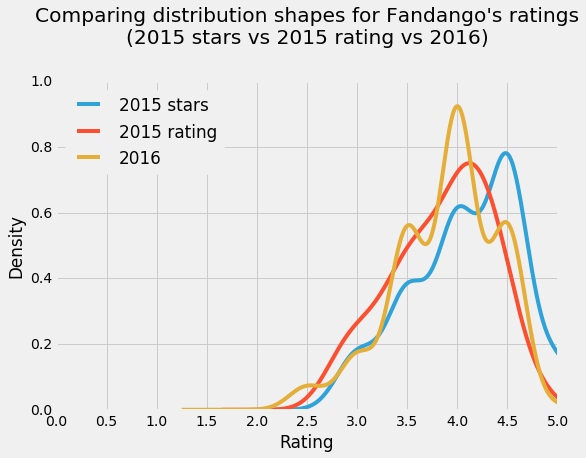

In [11]:
from numpy import arange
%matplotlib inline
plt.style.use('fivethirtyeight')

fandango_2015['Fandango_Stars'].plot.kde(label = '2015 stars', legend = True, figsize = (8,5.5))
fandango_2015['Fandango_Ratingvalue'].plot.kde(label = '2015 rating', legend = True)
fandango_2016['fandango'].plot.kde(label = '2016', legend = True)

plt.title("Comparing distribution shapes for Fandango's ratings\n(2015 stars vs 2015 rating vs 2016)",
          y = 1.1) 
plt.xlabel('Rating')
plt.xlim(0,5) # because ratings start at 0 and end at 5
plt.xticks(arange(0,5.1,.5))
plt.show()

As we can see, all charts have a left skewed tendency. At the same time 2015_stars chart has slightly higher ratings overall than 2015_values and 2016. The ratings of 2015_values and 2016 look more similar.

### Comparing Relative Frequencies

Now we need to analyze more granular information. Let's examine the frequency tables of the two distributions to analyze some numbers. Because the data sets have different numbers of movies, we normalize the tables and show percentages instead.

In [12]:
print('2015_stars' + '\n' + '*' * 16) 

fandango_2015['Fandango_Stars'].value_counts(normalize = True).sort_index() * 100

2015_stars
****************


3.0     8.527132
3.5    17.829457
4.0    28.682171
4.5    37.984496
5.0     6.976744
Name: Fandango_Stars, dtype: float64

In [13]:
print('2015_values' + '\n' + '*' * 16) 

fandango_2015['Fandango_Ratingvalue'].value_counts(normalize = True).sort_index() * 100

2015_values
****************


2.7     1.550388
2.8     1.550388
2.9     3.100775
3.0     3.100775
3.1     2.325581
3.2     3.100775
3.3     3.100775
3.4     5.426357
3.5     4.651163
3.6     6.201550
3.7     6.201550
3.8     3.100775
3.9     9.302326
4.0     5.426357
4.1    10.077519
4.2     8.527132
4.3     6.976744
4.4     5.426357
4.5     6.976744
4.6     1.550388
4.8     2.325581
Name: Fandango_Ratingvalue, dtype: float64

In [14]:
print('2016' + '\n' + '*' * 16) 

fandango_2016['fandango'].value_counts(normalize = True).sort_index() * 100

2016
****************


2.5     3.141361
3.0     7.329843
3.5    24.083770
4.0    40.314136
4.5    24.607330
5.0     0.523560
Name: fandango, dtype: float64

We have previously confirmed using tables that there is indeed a clear difference between the three distributions. The direction of the difference is not as clear as in the kernel density plots. In addition, the data for 2015_values is not too obvious, it's all about the unequal intervals of the column values.

### Summary statistics

We'll take each distribution of movie ratings and compute its mean, median, and mode, and then compare these statistics to determine what they tell about the direction of the difference.

In [107]:
sum_statistic = pd.DataFrame()

sum_statistic['2015_stars'] = [fandango_2015['Fandango_Stars'].mean(),
                               fandango_2015['Fandango_Stars'].median(),
                               fandango_2015['Fandango_Stars'].mode()[0]]
sum_statistic['2015_value'] = [fandango_2015['Fandango_Ratingvalue'].mean(),
                               fandango_2015['Fandango_Ratingvalue'].median(),
                               fandango_2015['Fandango_Ratingvalue'].mode()[0]]
sum_statistic['2016'] = [fandango_2016['fandango'].mean(),
                         fandango_2016['fandango'].median(),
                         fandango_2016['fandango'].mode()[0]]
sum_statistic.index = ['mean', 'median', 'mode']
sum_statistic

,2015_stars,2015_value,2016
mean,4.085271,3.846512,3.887435
median,4.000000,3.900000,4.000000
mode,4.500000,4.100000,4.000000


The mean rating was lower in 2016 with approximately 0.2. This means a drop of almost 5% relative to the mean rating in 2015.

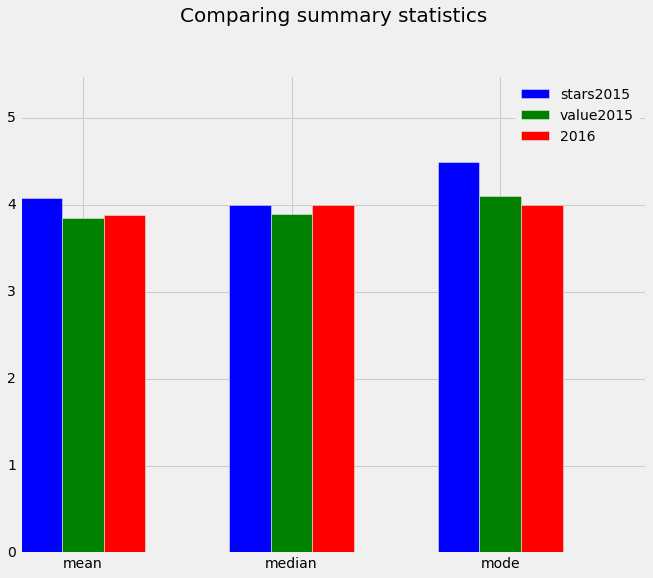

In [106]:
index = np.arange(3)
bw = 0.2
plt.figure(figsize=(10,8))
plt.axis([0,3,0,5.5])
plt.title('Comparing summary statistics', fontsize=20, y = 1.1)
plt.bar(index, sum_statistic['2015_stars'], bw,label='stars2015',  color='b')
plt.bar(index+bw, sum_statistic['2015_value'], bw, label='value2015',color='g')
plt.bar(index+2*bw, sum_statistic['2016'], bw, label='2016',color='r')
plt.xticks(index+1.5*bw,sum_statistic.index)
plt.legend(fontsize='medium')
plt.show()

As you can see in this graph, stars_2015 are generally higher than the rounded 2015 values and 2016 values, which are virtually the same. The average value of stars_2015 is higher than currencies_2015 and 2016 by about 0.2. That's about 5 percent of the overall rating!

Overall, we can conclude that Fandango fixed the biased rating system after Hickey's analysis. But we cannot be completely sure of this.